# Guided Project: Clean and Analyze Employee Exit Surveys

This project's goals are to analyse exit surveys from employees of the Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) institute in Queensland, Australia. The main questions I'm trying to answer are:
- **Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?**
- **Are younger employees resigning due to some kind of dissatisfaction? What about older employees?**

This project is an expanded Dataquest guided project idea - www.dataquest.io

In [1]:
from IPython.display import Markdown as md
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.style as style

In [2]:
dete_survey = pd.read_csv("dete_survey.csv")
tafe_survey = pd.read_csv("tafe_survey.csv")
pd.options.display.max_columns = None

## Initial data exploration

In [3]:
dete_survey.head()
dete_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   ID                                   822 non-null    int64 
 1   SeparationType                       822 non-null    object
 2   Cease Date                           822 non-null    object
 3   DETE Start Date                      822 non-null    object
 4   Role Start Date                      822 non-null    object
 5   Position                             817 non-null    object
 6   Classification                       455 non-null    object
 7   Region                               822 non-null    object
 8   Business Unit                        126 non-null    object
 9   Employment Status                    817 non-null    object
 10  Career move to public sector         822 non-null    bool  
 11  Career move to private sector        822 non-

In [4]:
tafe_survey.head()
tafe_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 72 columns):
 #   Column                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                         --------------  -----  
 0   Record ID                                                                                                                                                      702 non-null    float64
 1   Institute                                                                                                                                                      702 non-null    object 
 2   WorkArea                                                                                                                                  

#### Dropping unnecessary columns
The datasets provide a lot of information, although I will focus on the "dissatisfaction" columns, so most columns will be dropped. The reason is that data regarding factors of leaving other than dissatisfaction is not of concern to the project questions. Regarding the cleaning of data, dete_survey contains "Not Stated" values which describe that no value was given, they need to be transformed into NaN values. 

In [5]:
dete_survey = pd.read_csv("dete_survey.csv", na_values='Not Stated')
dete_survey.head()
dete_survey = dete_survey.drop(dete_survey.columns[28:49], axis=1)

#### Changing all column names to lowercase and replacing spaces with underscores
Cleaning the data by standarizing column names will make further analysis easier. Particular column names will be also changed so that they will match in both dataframes if they describe the same type of data.
##### Cleaning dete columns:

In [6]:
dete_survey.columns = dete_survey.columns.str.replace(' ', '_').str.lower().str.rstrip()
dete_survey.columns

Index(['id', 'separationtype', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'classification', 'region',
       'business_unit', 'employment_status', 'career_move_to_public_sector',
       'career_move_to_private_sector', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'work_location', 'employment_conditions',
       'maternity/family', 'relocation', 'study/travel', 'ill_health',
       'traumatic_incident', 'work_life_balance', 'workload',
       'none_of_the_above', 'gender', 'age', 'aboriginal', 'torres_strait',
       'south_sea', 'disability', 'nesb'],
      dtype='object')

##### Cleaning tafe columns:

In [7]:
tafe_survey = tafe_survey.drop(tafe_survey.columns[17:66], axis=1)
tafe_column_mapper = {'Record ID' : 'id', 'CESSATION YEAR' : 'cease_date', 'Reason for ceasing employment' : 'separationtype', 'Gender. What is your Gender?': 'gender', 'CurrentAge. Current Age' : 'age', 'Employment Type. Employment Type': 'employment_status', 'Classification. Classification': 'position', 'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service', 'LengthofServiceCurrent. Length of Service at current workplace (in years)' : 'role_service'}
tafe_survey = tafe_survey.rename(tafe_column_mapper, axis=1)
tafe_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 23 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   id                                                   702 non-null    float64
 1   Institute                                            702 non-null    object 
 2   WorkArea                                             702 non-null    object 
 3   cease_date                                           695 non-null    float64
 4   separationtype                                       701 non-null    object 
 5   Contributing Factors. Career Move - Public Sector    437 non-null    object 
 6   Contributing Factors. Career Move - Private Sector   437 non-null    object 
 7   Contributing Factors. Career Move - Self-employment  437 non-null    object 
 8   Contributing Factors. Ill Health                     437 non-null    o

## Filtering the data

#### To properly answer the project's questions about resigning employees only data concering employees that resigned should be kept.

In [8]:
dete_survey['separationtype'].value_counts()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64

In [9]:
tafe_survey['separationtype'].value_counts()

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64

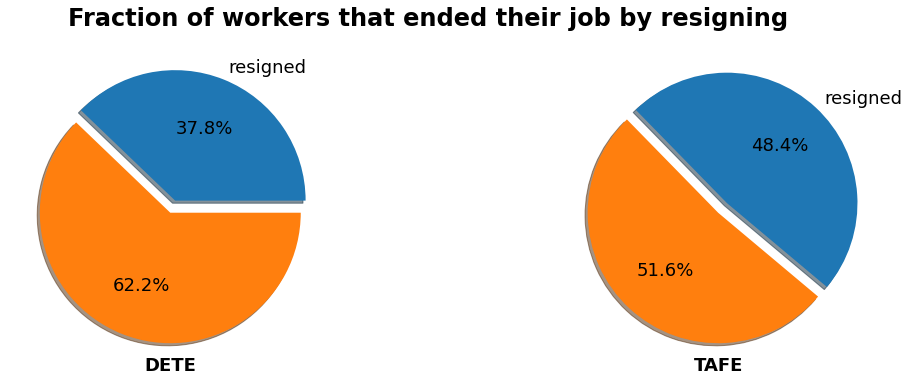

In [10]:
%matplotlib inline
dete_resigned = dete_survey[dete_survey['separationtype'].isin(['Resignation-Other reasons', 'Resignation-Other employer', 'Resignation-Move overseas/interstate'])].shape[0]
dete_nonresigned = dete_survey['separationtype'].shape[0] - dete_resigned
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
plt.suptitle("Fraction of workers that ended their job by resigning", fontsize=24, weight="bold")
explode= (0.1, 0)
ax1.pie([dete_resigned, dete_nonresigned], labels=['resigned', ''], explode=explode, autopct='%1.1f%%', shadow=True, textprops={'fontsize': 18})
ax1.set_title("DETE", y=0, fontdict={"fontsize": 18, "fontweight" : "bold"})

tafe_resigned = tafe_survey[tafe_survey['separationtype'] == 'Resignation'].shape[0]
tafe_nonresigned = tafe_survey['separationtype'].shape[0] - tafe_resigned
ax2.pie([tafe_resigned, tafe_nonresigned], labels=['resigned', ''], explode=explode, autopct='%1.1f%%', shadow=True, textprops={'fontsize': 18}, startangle=-40)
ax2.set_title("TAFE", y=0, fontdict={"fontsize": 18, "fontweight" : "bold"})
plt.show()

I create two new datasets that contain surveys by those employees that made a resignation, as this is my only concern in this study

In [11]:
dete_resignations = dete_survey[dete_survey['separationtype'].isin(['Resignation-Other reasons', 'Resignation-Other employer', 'Resignation-Move overseas/interstate'])].copy()
tafe_resignations = tafe_survey[tafe_survey['separationtype'] == 'Resignation']

#### Cleaning dete date columns - 'start_date' and 'cease_date' (beginning and end of job)

There are some data inconsistencies which need to be corrected in the dete dataframe - we are only interested in the year.

In [12]:
dete_resignations['cease_date'].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
11/2013      9
07/2013      9
10/2013      6
08/2013      4
05/2013      2
05/2012      2
2010         1
07/2012      1
07/2006      1
09/2010      1
Name: cease_date, dtype: int64

In [13]:
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.slice(start=-4).astype(float)
dete_resignations['cease_date'].value_counts().sort_index(ascending=False)

2014.0     22
2013.0    146
2012.0    129
2010.0      2
2006.0      1
Name: cease_date, dtype: int64

In [14]:
dete_resignations['dete_start_date'].value_counts().sort_index(ascending=False)

2013.0    10
2012.0    21
2011.0    24
2010.0    17
2009.0    13
2008.0    22
2007.0    21
2006.0    13
2005.0    15
2004.0    14
2003.0     6
2002.0     6
2001.0     3
2000.0     9
1999.0     8
1998.0     6
1997.0     5
1996.0     6
1995.0     4
1994.0     6
1993.0     5
1992.0     6
1991.0     4
1990.0     5
1989.0     4
1988.0     4
1987.0     1
1986.0     3
1985.0     3
1984.0     1
1983.0     2
1982.0     1
1980.0     5
1977.0     1
1976.0     2
1975.0     1
1974.0     2
1973.0     1
1972.0     1
1971.0     1
1963.0     1
Name: dete_start_date, dtype: int64

In [15]:
tafe_resignations['cease_date'].value_counts().sort_index(ascending=False)

2013.0     55
2012.0     94
2011.0    116
2010.0     68
2009.0      2
Name: cease_date, dtype: int64

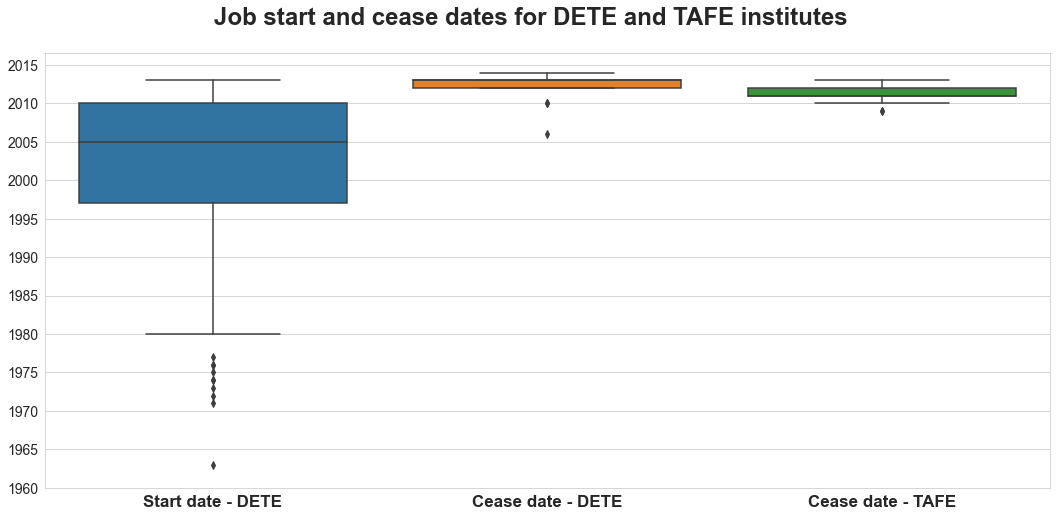

In [16]:
%matplotlib inline
bplot_df = pd.concat([dete_resignations['dete_start_date'], dete_resignations['cease_date'].rename('dete_cease_date'), tafe_resignations['cease_date'].rename('tafe_cease_date')], axis=1)
figure = plt.figure(figsize=(18,8))
sns.set_style("whitegrid")
sns.boxplot(data=bplot_df.loc[:, ['dete_start_date', 'dete_cease_date', 'tafe_cease_date']])
figure.suptitle('Job start and cease dates for DETE and TAFE institutes', fontsize=24, weight='bold', x=0.5, y=0.96)
axes = plt.gca()
plt.yticks(np.arange(1960, 2020, step=5))
axes.tick_params(axis='y', which='both', labelsize=14)
axes.tick_params(axis='x', which='both', labelsize=17)
xlabels = ['Start date - DETE', 'Cease date - DETE', 'Cease date - TAFE']
axes.set_xticklabels(xlabels, fontdict={'fontweight' :'bold'})
plt.show()

After further inspecting the dates, it looks like there are no logical inconsistencies in the data. The boxplots show some outliers, although they make sense in term of reality - it's very likely some workers started their job in the 1970s. There's no reason to leave out any data in the analysis.

To answer the question about dissatisfaction of those who worked for the institutes for a short period of time, we need a column that shows each employee's years of service. This column needs to be created for DETE based on dete_start_date and cease_date

In [17]:
dete_resignations['institute_service'] = dete_resignations['cease_date'] - dete_resignations['dete_start_date']

#### Cleaning the dissatisfaction columns
I will use a map function to transform this data into True/False values

##### TAFE Institute - dissatisfaction
Necessary data lies in two columns - 'Contributing Factors. Dissatisfaction' and 'Contributing Factors. Job Dissatisfaction'

In [18]:
tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts()

-                                         277
Contributing Factors. Dissatisfaction      55
Name: Contributing Factors. Dissatisfaction, dtype: int64

In [19]:
tafe_resignations['Contributing Factors. Job Dissatisfaction'].value_counts()

-                      270
Job Dissatisfaction     62
Name: Contributing Factors. Job Dissatisfaction, dtype: int64

In [20]:
def update_vals(value):
    if pd.isnull(value):
        return np.nan
    elif value == '-':
        return False
    else:
        return True

I create a new column 'dissatisfied', which shows if the employee marked his dissatisfaction in either of the 2 mentioned columns

In [21]:
cols = ['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']
tafe_resignations['dissatisfied'] = tafe_resignations.loc[:, cols].applymap(update_vals).any(axis=1, skipna=False)

<ipython-input-21-f03a9e89d545>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tafe_resignations['dissatisfied'] = tafe_resignations.loc[:, cols].applymap(update_vals).any(axis=1, skipna=False)


In [22]:
tafe_resignations['dissatisfied'].value_counts()

False    241
True      91
Name: dissatisfied, dtype: int64

I create a new dataframe for TAFE - tafe_resignations_up - which has the newly created 'dissatisfied column'

In [23]:
tafe_resignations_up = tafe_resignations.copy()

##### DETE Institute - dissatisfaction
There are more columns in the DETE data - all the names are listed below, and I use them to create a new dataframe - dete_resignations_up

In [24]:
dete_dissatisfaction_column_names = ['job_dissatisfaction', 'dissatisfaction_with_the_department', 'physical_work_environment', 'lack_of_recognition', 'lack_of_job_security', 'work_location', 'employment_conditions', 'work_life_balance', 'workload']

In [25]:
dete_resignations['dissatisfied'] =  dete_resignations.loc[:, dete_dissatisfaction_column_names].any(axis=1, skipna=False)
dete_resignations_up = dete_resignations.copy()
dete_resignations_up.head(10)

,id,separationtype,cease_date,dete_start_date,role_start_date,position,classification,region,business_unit,employment_status,career_move_to_public_sector,career_move_to_private_sector,interpersonal_conflicts,job_dissatisfaction,dissatisfaction_with_the_department,physical_work_environment,lack_of_recognition,lack_of_job_security,work_location,employment_conditions,maternity/family,relocation,study/travel,ill_health,traumatic_incident,work_life_balance,workload,none_of_the_above,gender,age,aboriginal,torres_strait,south_sea,disability,nesb,institute_service,dissatisfied
3,4,Resignation-Other reasons,2012.0,2005.0,2006.0,Teacher,Primary,Central Queensland,NaN,Permanent Full-time,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Female,36-40,NaN,NaN,NaN,NaN,NaN,7.0,False
5,6,Resignation-Other reasons,2012.0,1994.0,1997.0,Guidance Officer,NaN,Central Office,Education Queensland,Permanent Full-time,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,Female,41-45,NaN,NaN,NaN,NaN,NaN,18.0,True
8,9,Resignation-Other reasons,2012.0,2009.0,2009.0,Teacher,Secondary,North Queensland,NaN,Permanent Full-time,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Female,31-35,NaN,NaN,NaN,NaN,NaN,3.0,False
9,10,Resignation-Other employer,2012.0,1997.0,2008.0,Teacher Aide,NaN,NaN,NaN,Permanent Part-time,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Female,46-50,NaN,NaN,NaN,NaN,NaN,15.0,True
11,12,Resignation-Move overseas/interstate,2012.0,2009.0,2009.0,Teacher,Secondary,Far North Queensland,NaN,Permanent Full-time,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,Male,31-35,NaN,NaN,NaN,NaN,NaN,3.0,False
12,13,Resignation-Other reasons,2012.0,1998.0,1998.0,Teacher,Primary,Far North Queensland,NaN,Permanent Full-time,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,Female,36-40,NaN,NaN,NaN,NaN,NaN,14.0,False
14,15,Resignation-Other employer,2012.0,2007.0,2010.0,Teacher,Secondary,Central Queensland,NaN,Permanent Full-time,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Male,31-35,NaN,NaN,NaN,NaN,NaN,5.0,True
16,17,Resignation-Other reasons,2012.0,NaN,NaN,Teacher Aide,NaN,South East,NaN,Permanent Part-time,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,Male,61 or older,NaN,NaN,NaN,NaN,NaN,NaN,True
20,21,Resignation-Other employer,2012.0,1982.0,1982.0,Teacher,Secondary,Central Queensland,NaN,Permanent Full-time,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Male,56-60,NaN,NaN,NaN,NaN,NaN,30.0,False
21,22,Resignation-Other reasons,2012.0,1980.0,2009.0,Cleaner,NaN,Darling Downs South West,NaN,Permanent Part-time,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Female,51-55,NaN,NaN,NaN,NaN,NaN,32.0,False


In [26]:
dete_resignations_up['dissatisfied'].value_counts()

False    162
True     149
Name: dissatisfied, dtype: int64

**To summarize this step:**  
For the purpose of analysis, dete_resignations_up and tafe_resignations_up dataframes were created. Each has a special column 'dissatisfied' that combines all job dissatisfaction factor and shows True if the employee experienced any, and False if there was no dissatisfaction.

# Combining datasets

I will combine the two datasets while assigning the records a label - either 'DETE' or 'TAFE' in the column 'institute'. Then I will drop all columns that contain less than 500 non null values - those columns do not concern resignations and our analysis.

In [27]:
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True)
combined_updated = combined.dropna(axis=1, thresh=500).copy()
combined_updated.head(5)

,id,separationtype,cease_date,position,employment_status,gender,age,institute_service,dissatisfied,institute
0,4.0,Resignation-Other reasons,2012.0,Teacher,Permanent Full-time,Female,36-40,7.0,False,DETE
1,6.0,Resignation-Other reasons,2012.0,Guidance Officer,Permanent Full-time,Female,41-45,18.0,True,DETE
2,9.0,Resignation-Other reasons,2012.0,Teacher,Permanent Full-time,Female,31-35,3.0,False,DETE
3,10.0,Resignation-Other employer,2012.0,Teacher Aide,Permanent Part-time,Female,46-50,15.0,True,DETE
4,12.0,Resignation-Move overseas/interstate,2012.0,Teacher,Permanent Full-time,Male,31-35,3.0,False,DETE


Now I check the combined dataframe for null values. There is not a lot of them, so I decided not to drop any rows from the data.

In [28]:
combined_updated.loc[combined_updated['dissatisfied'] == True].isna().sum()

id                    0
separationtype        0
cease_date            5
position             16
employment_status    15
gender               16
age                  14
institute_service    26
dissatisfied          0
institute             0
dtype: int64

# Length of service and dissatisfaction
## Cleaning the 'insitute_service' column
This column has a lot of different values - it needs to be cleaned, and I decide to bundle those numbers into groups

In [29]:
combined_updated = combined_updated.astype({'institute_service':str})
combined_updated['institute_service'].value_counts(dropna=False)

nan                   88
Less than 1 year      73
1-2                   64
3-4                   63
5-6                   33
11-20                 26
5.0                   23
1.0                   22
7-10                  21
0.0                   20
3.0                   20
6.0                   17
4.0                   16
2.0                   14
9.0                   14
7.0                   13
More than 20 years    10
8.0                    8
13.0                   8
15.0                   7
20.0                   7
10.0                   6
12.0                   6
14.0                   6
17.0                   6
22.0                   6
16.0                   5
18.0                   5
23.0                   4
11.0                   4
24.0                   4
21.0                   3
32.0                   3
39.0                   3
19.0                   3
26.0                   2
28.0                   2
36.0                   2
30.0                   2
25.0                   2


In [30]:
combined_updated['institute_service'] = combined_updated['institute_service'].str.extract(r'(\d+)').astype('float')

#### A new column 'service_cat' will show service_length groups based on following conditions on work experience:  

-New: <3 years  
-Experienced: <7 years  
-Established: <11 years  
-Veteran: 11 and above  

This will allow me to answer the question about correlation of work length and dissatisfaction. 
Source: https://www.businesswire.com/news/home/20171108006002/en/Age-Number-Engage-Employees-Career-Stage  
  
I will use a custom function to map the dataframe

In [31]:
def map_service_length(value):
    if pd.isnull(value):
        return np.nan
    elif value < 3:
        return 'New'
    elif value < 7:
        return 'Experienced'
    elif value < 11:
        return 'Established'
    else:
        return 'Veteran'

In [32]:
combined_updated['service_cat'] = combined_updated['institute_service'].apply(map_service_length)
combined_updated['dissatisfied'].value_counts(dropna=False)

False    403
True     240
NaN        8
Name: dissatisfied, dtype: int64

In [33]:
most_common = combined_updated['dissatisfied'].value_counts().idxmax()
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(most_common)
combined_updated_pivot = combined_updated.pivot_table(index='service_cat', values='dissatisfied')
order = ['New', 'Experienced', 'Established', 'Veteran']
combined_updated_pivot

,dissatisfied
service_cat,
Established,0.516129
Experienced,0.343023
New,0.295337
Veteran,0.485294


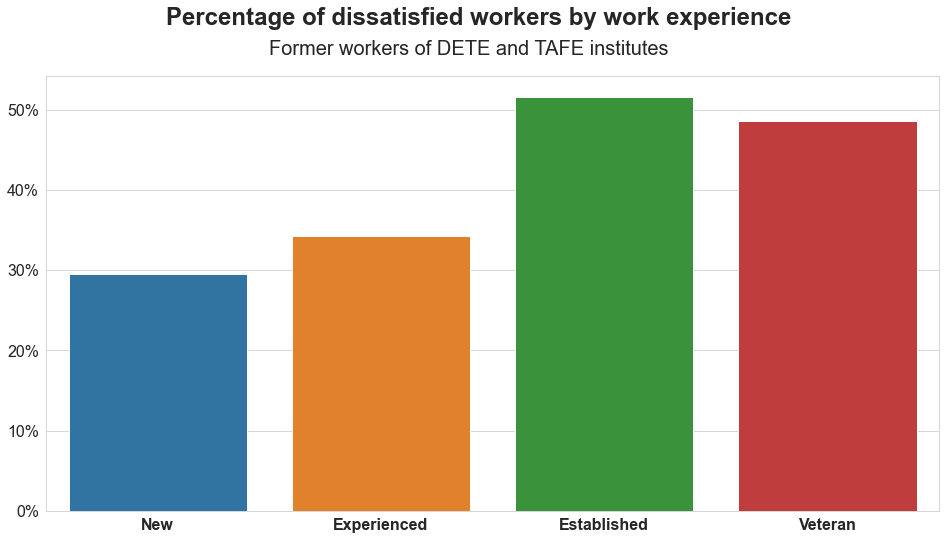

In [34]:
%matplotlib inline
figure = plt.figure(figsize=(16, 8))
sns.barplot(data=combined_updated, y='dissatisfied', x='service_cat', order=['New', 'Experienced', 'Established', 'Veteran'], ci=None)
axes = plt.gca()
axes.xaxis.label.set_visible(False)
axes.yaxis.label.set_visible(False)
axes.tick_params(axis='both', which='both', labelsize=16)
figure.suptitle('Percentage of dissatisfied workers by work experience', x=0.5, y=1, fontsize=24, weight='bold')
axes.text(x=0.25, y=1.05, s='Former workers of DETE and TAFE institutes', transform=axes.transAxes, fontsize=20)
axes.set_xticklabels(axes.get_xticklabels(), fontdict={'fontweight':'bold'})
axes.get_yaxis().set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

#### Observations:
- The highest dissatisfaction is among the Established (7-10 years) and Veteran (11+ years). This means that if somebody who worked in the company for a long time left, it was more likely than not that it was due to dissatisfaction.
- In the less experienced groups (<7 years), only around 1/3 left due to dissatisfaction.

This means that the longer the tenure, the more likely that if somebody leaves, it is due to dissatisfaction.

# Age of worker and dissatisfaction


I will analyze the age groups and check if there is a connection between older age and dissatisfaction when leaving the job.

In [35]:
combined_updated['age'].value_counts()

51-55            71
41-45            48
41  45           45
46-50            42
36-40            41
46  50           39
26-30            35
21  25           33
31  35           32
36  40           32
26  30           32
21-25            29
31-35            29
56 or older      29
56-60            26
61 or older      23
20 or younger    10
Name: age, dtype: int64

In [36]:
combined_updated['age'] = combined_updated['age'].str.extract(r'(\d+)').astype(float)
combined_updated['age'].value_counts()

41.0    93
46.0    81
36.0    73
51.0    71
26.0    67
21.0    62
31.0    61
56.0    55
61.0    23
20.0    10
Name: age, dtype: int64

Once again, I will use a function to map the age data - I'm interested in following groups:
- **20 or younger**
- **20s**
- **30s**
- **40s**
- **50s**
- **60 or older**

In [37]:
def map_age_groups(value):
    if pd.isnull(value):
        return np.nan
    elif value <= 20:
        return '20 or younger'
    elif value < 30:
        return '20s'
    elif value < 40:
        return '30s'
    elif value < 50:
        return '40s'
    elif value < 60:
        return '50s'
    else:
        return '60 or older'
    
combined_updated['age'] = combined_updated['age'].apply(map_age_groups)
combined_updated

,id,separationtype,cease_date,position,employment_status,gender,age,institute_service,dissatisfied,institute,service_cat
0,4.000000e+00,Resignation-Other reasons,2012.0,Teacher,Permanent Full-time,Female,30s,7.0,False,DETE,Established
1,6.000000e+00,Resignation-Other reasons,2012.0,Guidance Officer,Permanent Full-time,Female,40s,18.0,True,DETE,Veteran
2,9.000000e+00,Resignation-Other reasons,2012.0,Teacher,Permanent Full-time,Female,30s,3.0,False,DETE,Experienced
3,1.000000e+01,Resignation-Other employer,2012.0,Teacher Aide,Permanent Part-time,Female,40s,15.0,True,DETE,Veteran
4,1.200000e+01,Resignation-Move overseas/interstate,2012.0,Teacher,Permanent Full-time,Male,30s,3.0,False,DETE,Experienced
...,...,...,...,...,...,...,...,...,...,...,...
646,6.350660e+17,Resignation,2013.0,Operational (OO),Temporary Full-time,Male,20s,5.0,False,TAFE,Experienced
647,6.350668e+17,Resignation,2013.0,Teacher (including LVT),Temporary Full-time,Male,50s,1.0,False,TAFE,New
648,6.350677e+17,Resignation,2013.0,NaN,NaN,NaN,NaN,NaN,False,TAFE,NaN
649,6.350704e+17,Resignation,2013.0,Teacher (including LVT),Permanent Full-time,Female,50s,5.0,False,TAFE,Experienced


I create a pivot table for the purpose of displaying a bar plot

In [38]:
age_dissatisfied_pivot = combined_updated.pivot_table(index='age', values='dissatisfied')
age_dissatisfied_pivot

,dissatisfied
age,
20 or younger,0.200000
20s,0.364341
30s,0.358209
40s,0.379310
50s,0.404762
60 or older,0.521739


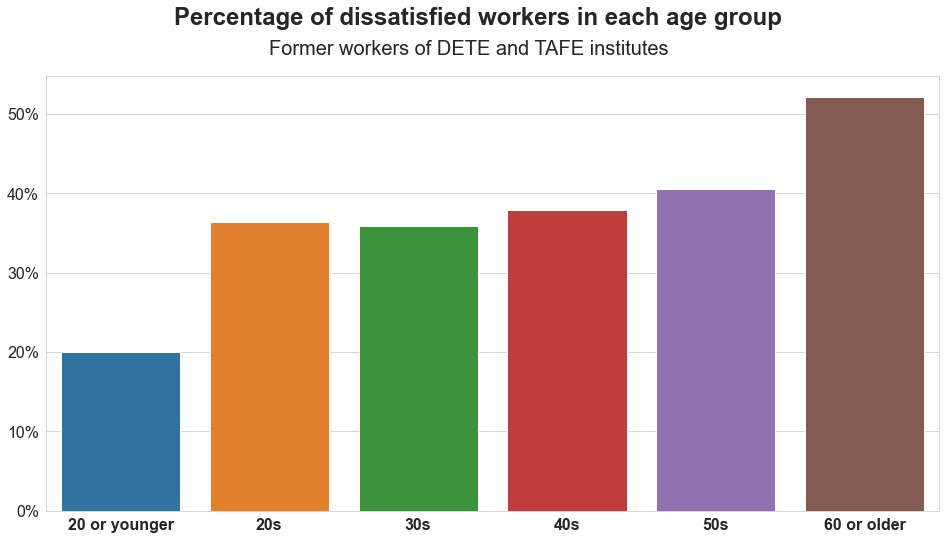

In [39]:
%matplotlib inline
figure = plt.figure(figsize=(16, 8))
sns.barplot(data=combined_updated, y='dissatisfied', x='age', order=['20 or younger', '20s', '30s', '40s', '50s', '60 or older'], ci=None)
axes = plt.gca()
axes.xaxis.label.set_visible(False)
axes.yaxis.label.set_visible(False)
axes.tick_params(axis='both', which='both', labelsize=16)
figure.suptitle('Percentage of dissatisfied workers in each age group', x=0.5, y=1, fontsize=24, weight='bold')
axes.text(x=0.25, y=1.05, s='Former workers of DETE and TAFE institutes', transform=axes.transAxes, fontsize=20)
axes.set_xticklabels(axes.get_xticklabels(), fontdict={'fontweight':'bold'})
axes.get_yaxis().set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# Conclusions:

This analysis allowed me to answer the questions stated at the beginning:
- **Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?**

    Out of the employees who worked for DETE or TAFE for a short period of time, only approximately 1/3 is resigning due to some kind of dissatisfaction experienced in the workplace. This number rises in the more experienced group - out of those who have worked 7 years or more, nearly half declares that they were dissatisfied.

- **Are younger employees resigning due to some kind of dissatisfaction? What about older employees?**

    When we consider the youngest employees, only 1 out of 5 leaves because of some dissatisfaction. This means that a job in those institutes generally satisfies very young students (20 or younger). There is a visible trend, however, in the older groups. In the groups of 20s, 30s, 40s and 50s this ratio rises to approximately 1 out of 3 former workers being dissatisfied. In the oldest group, 60 years or older, more than a half of the workers that leave do it due to dissatisfaction
